In [33]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import PorterStemmer, LancasterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords

import emoji
import re 

import numpy as np
import pandas as pd
from collections import Counter
import string

import matplotlib.pyplot as plt
plt.rcParams.update({'xtick.labelcolor':"white", 'ytick.labelcolor':"white", 'axes.titlecolor':"white", 'axes.labelcolor':"white"})
import seaborn as sns

# Donald Trump Tweets Data

In [259]:
df = pd.read_csv('data/trump_tweets/trumptweets.csv')

In [205]:
df.shape

(41122, 9)

# 틈새 EDA

In [206]:
df['date'].min(), df['date'].max() # 코로나 관련 트윗 없음

('2009-05-04 20:54:25', '2020-01-20 02:57:49')

In [260]:
df['year'] = df['date'].map(lambda x: x[:4])

In [208]:
[(str(i), len(df[df['year']==str(i)])) for i in range(2009,2021)]
# 연도별 트윗 수

[('2009', 56),
 ('2010', 143),
 ('2011', 870),
 ('2012', 4190),
 ('2013', 8207),
 ('2014', 5987),
 ('2015', 7719),
 ('2016', 3951),
 ('2017', 2232),
 ('2018', 2998),
 ('2019', 4588),
 ('2020', 181)]

In [258]:
[(str(i), round(len(df[df['year']==str(i)])/365,2)) for i in range(2009,2021)]
# 연도별 하루 평균 트윗 수

[('2009', 0.15),
 ('2010', 0.39),
 ('2011', 2.38),
 ('2012', 11.48),
 ('2013', 22.48),
 ('2014', 16.4),
 ('2015', 21.15),
 ('2016', 10.82),
 ('2017', 6.12),
 ('2018', 8.21),
 ('2019', 12.57),
 ('2020', 0.5)]

In [210]:
df['content'][df['retweets']==295817] # 두번째로 리트윗 많은 트윗

30895    TODAY WE MAKE AMERICA GREAT AGAIN!
Name: content, dtype: object

In [211]:
df['content'][df['favorites']==df['favorites'].max()].values # 좋아요 가장 많은 트윗

array(['A$AP Rocky released from prison and on his way home to the United States from Sweden. It was a Rocky Week, get home ASAP A$AP!'],
      dtype=object)

# 데이터 전처리

## 전처리 함수 생성

In [212]:


# Spelling Correction
def edits1(word):
    letters='abcdefghijklmnopqrstuvwxyz'
    splits=[(word[:i], word[i:]) for i in range(len(word)+1)]
    deletes=[L+R[1:] for L,R in splits if R]
    transposes=[L+R[1] +R[0] + R[2:] for L,R in splits if len(R)>1]
    replaces = [L+c+R[# Removing weird spaces
def remove_spaces(text):
    text=text.strip()
    text=text.split()
    return ' '.join(text)1:] for L,R in splits if R for c in letters]
    inserts = [L+c+ R for L,R in splits for c in letters]
    return set(deletes+transposes+replaces+inserts)
def edits2(word):
    return(e2 for e1 in edits1(word) for e2 in edits1(e1))

# Contraction(줄임말 되돌리기)
contraction = {'cause':'because',
              'aint': 'am not',
              'aren\'t': 'are not',
              'don\'t' : 'do not',
              'doesn\'t' : 'does not',
              'haven\'t' : 'have not',
              'hasn\'t' : 'has not'}

def mapping_replacer(x,dic):
    for words in dic.keys():
        if ' ' + words + ' ' in x:
            x=x.replace(' '+ words +' ' ,' '+dic[words]+' ' )
    return x

In [213]:
# tokenisation and lemmetisation

lem = WordNetLemmatizer()
def lexicon_normalization(text):
    words = word_tokenize(text) 
    
    # Stemming
    # words_stem = [ls.stem(w) for w in words]
    
    # Lemmatizing
    words_lem = [lem.lemmatize(w) for w in words]
   
    return words_lem

In [261]:
# hashtag, @(언급) 삭제 함수
def remove_etc(text):
    text = re.sub('@\s\w+','',text)
    text = re.sub('pic.\w+.com/\w+','',text)
    text = re.sub('#[\w_]+', '', text)
    text = re.sub('[\w.]+.com','',text)
    return text

In [214]:
# Handling emojis

# import emoji
# import re 
#from emot.emo_unicode import UNICODE_EMO
def convert_emojis(text):
    for emot in emoji.UNICODE_EMOJI:
        text = re.sub(r'('+emot+')', "_".join(emoji.UNICODE_EMOJI[emot].replace(",","").replace(":","").split()), text)
    return text

In [215]:
# Removing links, brackets, numbers, punctuations etc.

def clean_text(text):
    # '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    # and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\'','', text)
    text = re.sub('@ [\w]+','', text)
    text = re.sub('http','', text)
                  
    
    return text

In [216]:
# Handling stopwords
custom_stopwords = ['trump', 'http', 'com', 'tinyurl',
                    'twitter', 'tweet', 'www', 'ly', 'donald',
                    'u', 'cont', 'p', 'realdonaldtrump',
                    'bit', 'gd', 'tl', 'pqpfvm']
custom_dict = Counter(custom_stopwords)

from collections import Counter
def remove_stopword(text):
    stop_words = stopwords.words('english')
    stopwords_dict = Counter(stop_words)
    text = ' '.join([word for word in text.split() if word not in stopwords_dict])
    text = ' '.join([word for word in text.split() if word not in custom_dict])
    return text

In [217]:
def one_letter_remove(text):
    return [i for i in text if len(i)>1]

In [218]:
# Word Tokenisation

def tokenise(text):
    words = word_tokenize(text) 
    return words

## 전처리 함수 적용

In [264]:
# hashtag, 언급 삭제
df['content_clean'] = df['content'].map(lambda x: remove_etc(x))

In [265]:
# 문자 아닌 것 삭제
df['content_clean'] = df['content_clean'].map(lambda x: re.sub(r'\W+', ' ', x))
# train['content'] = train['content'].replace(r'\W+', ' ', regex=True)

In [266]:
# 줄임말을 원형으로 되돌리기 (ain't -> am not)
df['content_clean']=df['content_clean'].apply(lambda x: mapping_replacer(x, contraction))

In [267]:
# https라던가 링크주소 같은 거 삭제해주는 함수
df['content_clean'] = df['content_clean'].apply(lambda x:clean_text(x))

In [268]:
# 불용어 제거 함수
df['content_clean']=df['content_clean'].apply(lambda x: remove_stopword(x))

In [269]:
# word tokenization, lemmatization 함수
df['content_norm'] = df['content_clean'].apply(lambda x: lexicon_normalization(x))

In [270]:
# 한 글자 짜리 단어 삭제하는 함수
df['content_norm'] = df['content_norm'].map(lambda x: one_letter_remove(x))

# 연도별 가장 많이 언급한 단어

In [271]:
mydf = []
for year in range(2009,2021):
    mydf.append( df[ df['year']== f'{year}' ] )

In [272]:
mydf[0]['content_norm']

0     [sure, tune, watch, late, night, david, letter...
1     [appearing, view, tomorrow, morning, discus, c...
2     [read, top, ten, financial, tip, late, show, d...
3     [new, blog, post, celebrity, apprentice, final...
4     [persona, never, wallflower, rather, build, wa...
5     [miss, usa, tara, conner, fired, always, belie...
6     [listen, interview, discussing, new, book, thi...
7      [strive, wholeness, keep, sense, wonder, intact]
8     [enter, think, like, champion, signed, book, k...
9              [achiever, achieves, plateau, beginning]
10           [afraid, unique, like, afraid, best, self]
11                  [win, life, champion, view, moment]
12    [day, could, use, little, power, trumpative, t...
13    [always, know, could, precipice, something, gr...
14    [read, great, interview, appeared, new, york, ...
15                [keep, fast, short, direct, whatever]
16    [forget, enter, think, like, champion, signed,...
17            [know, facebook, donaldtrump, fan,

In [273]:
top_list = []
for d in mydf:
    top = Counter( [item for sublist in d['content_norm'] for item in sublist] )
    top_list.append(top.most_common(1))

top_list

[[('champion', 10)],
 [('apprentice', 39)],
 [('china', 79)],
 [('obama', 472)],
 [('thanks', 1282)],
 [('great', 788)],
 [('great', 1088)],
 [('thank', 640)],
 [('great', 478)],
 [('great', 811)],
 [('great', 979)],
 [('status', 46)]]

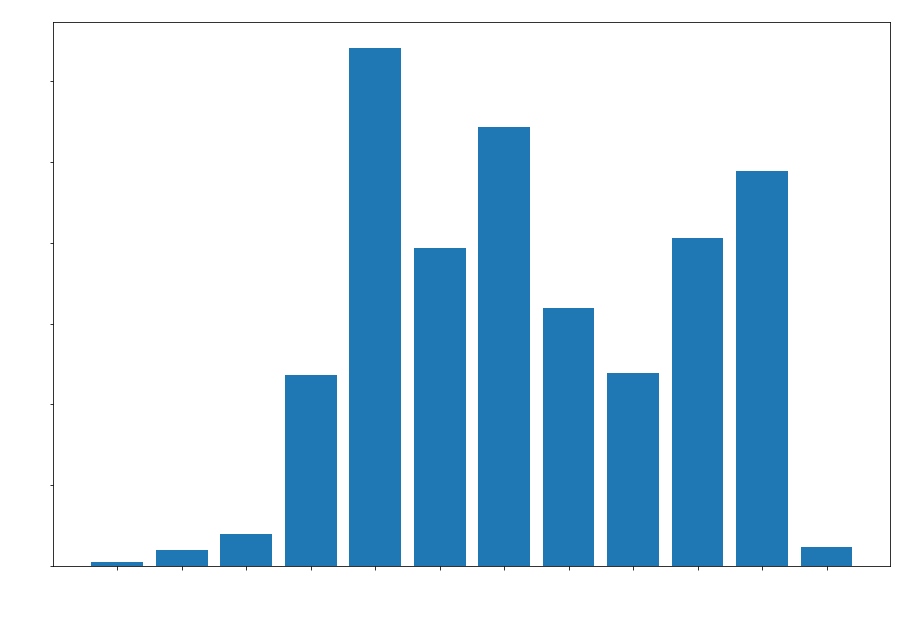

In [274]:
plt.figure(figsize=(15,10))
plt.title("Most Frequent Word Over Years")
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.bar(np.arange(2009,2021), [i[0][1] for i in top_list])
plt.xticks(np.arange(2009,2021),
           labels = [i[0][0] for i in top_list],
           rotation = 45)
plt.show()

# Great이라는 단어와 많이 쓰인 단어
co-occurence 행렬

In [230]:
import nltk
from nltk import bigrams
import itertools

In [275]:
tokens = df['content_norm']

In [276]:
def generate_co_occurrence_matrix(corpus):
    vocab = set(corpus)
    vocab = list(vocab)
    vocab_index = {word: i for i, word in enumerate(vocab)}
 
    # Create bigrams from all words in corpus
    bi_grams = list(bigrams(corpus))
 
    # Frequency distribution of bigrams ((word1, word2), num_occurrences)
    bigram_freq = nltk.FreqDist(bi_grams).most_common(len(bi_grams))
 
    # Initialise co-occurrence matrix
    # co_occurrence_matrix[current][previous]
    co_occurrence_matrix = np.zeros((len(vocab), len(vocab)))
 
    # Loop through the bigrams taking the current and previous word,
    # and the number of occurrences of the bigram.
    for bigram in bigram_freq:
        current = bigram[0][1]
        previous = bigram[0][0]
        count = bigram[1]
        pos_current = vocab_index[current]
        pos_previous = vocab_index[previous]
        co_occurrence_matrix[pos_current][pos_previous] = count
    co_occurrence_matrix = np.matrix(co_occurrence_matrix)
 
    # return the matrix and the index
    return co_occurrence_matrix, vocab_index

In [277]:
data = list(itertools.chain.from_iterable(tokens))
matrix, vocab_index = generate_co_occurrence_matrix(data)
 
 
 
data_matrix = pd.DataFrame(matrix, index=vocab_index,
                             columns=vocab_index)

In [278]:
co_occurence = pd.DataFrame(data_matrix)

In [279]:
co_occurence['great'][co_occurence['great']!=0].sort_values(ascending = False)[:10]

job       356.0
honor     191.0
state     154.0
people    128.0
guy       106.0
new        92.0
thanks     88.0
news       86.0
time       82.0
day        80.0
Name: great, dtype: float64

# Most Similar

In [236]:
from gensim.models import word2vec

In [280]:
# 모델 학습
model = word2vec.Word2Vec(tokens, min_count=1) # default: window=5 및 많은 파라미터들이 생략되어있다
model

In [238]:
model.wv.most_similar('korea')

[('north', 0.8940448760986328),
 ('carolina', 0.8480803966522217),
 ('meeting', 0.8297947645187378),
 ('jong', 0.8247636556625366),
 ('kim', 0.8189870119094849),
 ('japan', 0.8170467019081116),
 ('progress', 0.8115001916885376),
 ('south', 0.8058237433433533),
 ('korean', 0.8047173023223877),
 ('constructive', 0.8031324148178101)]

In [239]:
model.wv.most_similar('america')

[('safe', 0.8835620284080505),
 ('collapsing', 0.8815787434577942),
 ('taxreform', 0.8569282293319702),
 ('pleasurable', 0.8569278717041016),
 ('safer', 0.8567718267440796),
 ('together', 0.8557207584381104),
 ('sense', 0.8453325629234314),
 ('feared', 0.8389703631401062),
 ('successor', 0.8387880325317383),
 ('sure', 0.8383418917655945)]

In [240]:
model.wv.most_similar('mexico')

[('barrier', 0.9624433517456055),
 ('tariff', 0.9524432420730591),
 ('company', 0.9345176815986633),
 ('paying', 0.9345058798789978),
 ('balance', 0.934367299079895),
 ('build', 0.9339078664779663),
 ('pay', 0.9338939785957336),
 ('negotiate', 0.929522693157196),
 ('oil', 0.9270881414413452),
 ('advantage', 0.9269593954086304)]

In [241]:
model.wv.most_similar('barack')

[('failed', 0.9848582744598389),
 ('lied', 0.9801041483879089),
 ('told', 0.9796590209007263),
 ('evidence', 0.9764724373817444),
 ('spy', 0.9755181074142456),
 ('investigating', 0.9752909541130066),
 ('scandal', 0.9747331142425537),
 ('gave', 0.9746818542480469),
 ('guilty', 0.9746768474578857),
 ('schumer', 0.9745321273803711)]

In [242]:
model.wv.most_similar('money')

[('pay', 0.9575632810592651),
 ('oil', 0.9488975405693054),
 ('cost', 0.9441719651222229),
 ('iraq', 0.9403790831565857),
 ('borrow', 0.9381564855575562),
 ('isi', 0.925510823726654),
 ('others', 0.9237850904464722),
 ('emphasize', 0.9230405688285828),
 ('overrun', 0.9187468886375427),
 ('wasted', 0.9182301759719849)]

In [243]:
model.wv.most_similar('fed')

[('gain', 0.9931682348251343),
 ('plus', 0.9931095838546753),
 ('complaining', 0.9929308295249939),
 ('charity', 0.9928843379020691),
 ('effective', 0.990690290927887),
 ('slow', 0.9899290800094604),
 ('due', 0.9894296526908875),
 ('mortgage', 0.9892332553863525),
 ('sell', 0.9889922142028809),
 ('rising', 0.9886729121208191)]

In [244]:
model.wv.most_similar('dirty')

[('server', 0.9918999671936035),
 ('cop', 0.9917379021644592),
 ('schiff', 0.9908855557441711),
 ('spy', 0.9907859563827515),
 ('led', 0.990623414516449),
 ('frame', 0.9897556304931641),
 ('podesta', 0.9896600842475891),
 ('influence', 0.9894254207611084),
 ('fraud', 0.9889753460884094),
 ('investigate', 0.9886890053749084)]

# Similarity

In [245]:
model.wv.similarity('dumb', 'barackobama')

0.94889873

In [246]:
model.wv.similarity('dumb', 'biden')

0.9773561

In [247]:
model.wv.similarity('dumb', 'trump')

0.9178681

In [248]:
model.wv.similarity('make', 'america')

0.7306885

In [249]:
model.wv.similarity('korea', 'japan')

0.8170469

In [250]:
model.wv.similarity('korea', 'china')

0.70104223

#  

# 감성분석, 워드클라우드

In [251]:
import re
import string
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import nltk
from nltk.corpus import stopwords

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

import warnings
warnings.filterwarnings("ignore")

import os

In [252]:
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator

from textblob import TextBlob

def get_tweet_sentiment(tweet): 
    ''' 
    Utility function to classify sentiment of passed tweet 
    using textblob's sentiment method 
    '''
    # create TextBlob object of passed tweet text 
    analysis = TextBlob(tweet) 
    
    # set sentiment 
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0: 
        return 'neutral'
    else: 
        return 'negative'

In [253]:
df['sentiment']=df['content_norm'].apply(lambda x: get_tweet_sentiment(' '.join(x)))

In [254]:
df.head()

,id,link,content,date,retweets,favorites,mentions,hashtags,geo,year,content_clean,content_norm,sentiment
0,1698308935,https://twitter.com/realDonaldTrump/status/169...,Be sure to tune in and watch Donald Trump on L...,2009-05-04 20:54:25,500,868,NaN,NaN,NaN,2009,sure tune watch late night david letterman pre...,"[sure, tune, watch, late, night, david, letter...",positive
1,1701461182,https://twitter.com/realDonaldTrump/status/170...,Donald Trump will be appearing on The View tom...,2009-05-05 03:00:10,33,273,NaN,NaN,NaN,2009,appearing view tomorrow morning discuss celebr...,"[appearing, view, tomorrow, morning, discus, c...",positive
2,1737479987,https://twitter.com/realDonaldTrump/status/173...,Donald Trump reads Top Ten Financial Tips on L...,2009-05-08 15:38:08,12,18,NaN,NaN,NaN,2009,reads top ten financial tips late show david l...,"[read, top, ten, financial, tip, late, show, d...",positive
3,1741160716,https://twitter.com/realDonaldTrump/status/174...,New Blog Post: Celebrity Apprentice Finale and...,2009-05-08 22:40:15,11,24,NaN,NaN,NaN,2009,new blog post celebrity apprentice finale less...,"[new, blog, post, celebrity, apprentice, final...",positive
4,1773561338,https://twitter.com/realDonaldTrump/status/177...,"""My persona will never be that of a wallflower...",2009-05-12 16:07:28,1399,1965,NaN,NaN,NaN,2009,persona never wallflower rather build walls cl...,"[persona, never, wallflower, rather, build, wa...",neutral


In [255]:
Positive_sent = df[df['sentiment']=='positive']
Negative_sent = df[df['sentiment']=='negative']
Neutral_sent = df[df['sentiment']=='neutral']

In [256]:
print('Number of tweets with positive sentiment', Positive_sent['sentiment'].count())
print('Number of tweets with negative sentiment', Negative_sent['sentiment'].count())
print('Number of tweets with neutral sentiment', Neutral_sent['sentiment'].count())

Number of tweets with positive sentiment 22664
Number of tweets with negative sentiment 7166
Number of tweets with neutral sentiment 11292


In [ ]:
#MosT common positive words
top = Counter([item for sublist in Positive_sent['content'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,great,6133
1,twitter,2270
2,thanks,2262
3,new,1631
4,thank,1631
5,good,1569
6,president,1569
7,people,1489
8,america,1313
9,country,1289


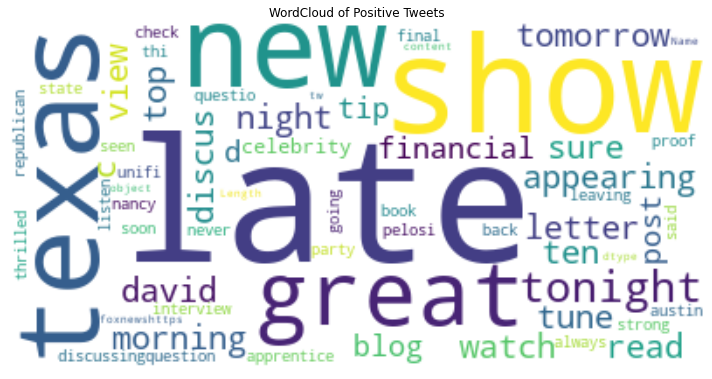

In [ ]:
wc = WordCloud( width=400, 
                height=200,
                max_font_size=100,
                background_color='white',
                max_words=200)
gen = wc.generate( str(Positive_sent.content))
plt.figure( figsize=(10,8))
plt.title('WordCloud of Positive Tweets')
plt.imshow( gen, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
#MosT common negative words
top = Counter([item for sublist in Negative_sent['content'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Reds')

,Common_words,count
1,people,678
2,news,573
3,obama,564
4,fake,548
5,time,525
6,president,521
7,country,502
8,democrat,463
9,get,461
10,never,428


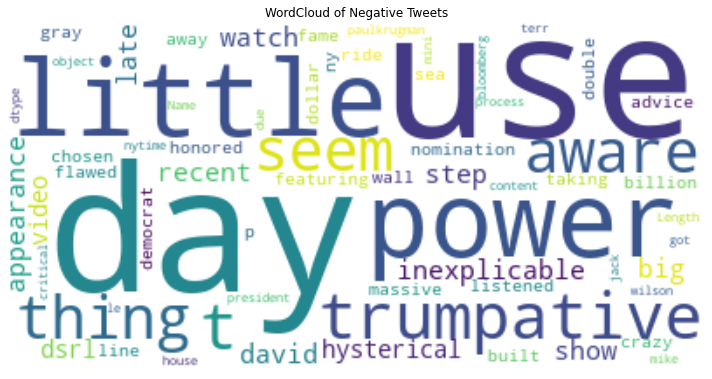

In [ ]:
wc = WordCloud( width=400, 
                height=200,
                max_font_size=100,
                background_color='white',
                max_words=200)
gen = wc.generate( str(Negative_sent.content))
plt.figure( figsize=(10,8))
plt.title('WordCloud of Negative Tweets')
plt.imshow( gen, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
#MosT common Neutral words
top = Counter([item for sublist in Neutral_sent['content'] for item in sublist])
temp_neutral = pd.DataFrame(top.most_common(20))
temp_neutral = temp_neutral.loc[1:,:]
temp_neutral.columns = ['Common_words','count']
temp_neutral.style.background_gradient(cmap='Greys')

,Common_words,count
1,thank,1018
2,president,897
3,bit,810
4,obama,569
5,run,505
6,via,484
7,status,468
8,need,449
9,get,434
10,vote,414


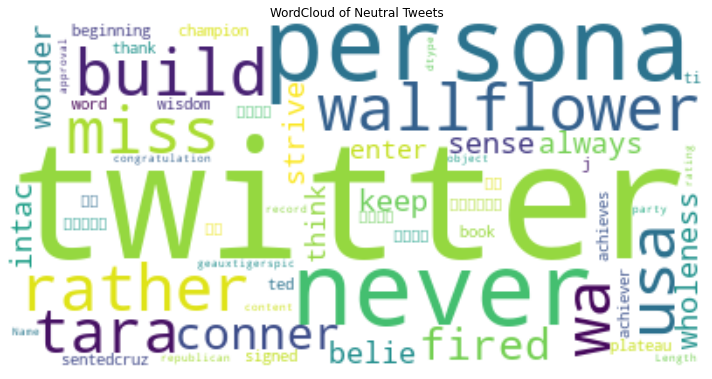

In [ ]:
wc = WordCloud( width=400, 
                height=200,
                max_font_size=100,
                background_color='white',
                max_words=200)
gen = wc.generate( str(Neutral_sent.content))
plt.figure( figsize=(10,8))
plt.title('WordCloud of Neutral Tweets')
plt.imshow( gen, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()